# Lab 3 - Query Expansion

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [2]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


349

In [3]:
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

In [4]:
import umap

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
  0%|          | 0/349 [00:00<?, ?it/s]/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 1/349 [00:00<05:11,  1.12it/s]/Users/mdp/Desktop/fu

## Expansion with generated answers

https://arxiv.org/abs/2305.03653

In [5]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ] 

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [6]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? In the past
fiscal year, there was significant turnover in the executive team with
three key members departing and four new executives joining the
company. The changes were driven by a strategic shift in the company's
direction and a desire to bring in fresh perspectives to lead the
organization forward. The new executives bring a wealth of experience
and expertise to their respective roles, and we are confident that they
will contribute to the continued success of the company.


In [7]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

89 directors and executive officers of microsoft corporation directors
satya nadella chairman and chief executive officer, microsoft
corporation sandra e. peterson 2, 3 operating partner, clayton,
dubilier & rice, llc john w. stanton 1, 4 founder and chairman, trilogy
partnerships reid g. hoffman 4 general partner, greylock partners penny
s. pritzker 4 founder and chairman, psp partners, llc john w. thompson
3, 4 lead independent director, microsoft corporation hugh f. johnston
1 vice chairman and executive vice president and chief financial
officer, pepsico, inc. carlos a. rodriguez 1 chief executive officer,
adp, inc. emma n. walmsley 2, 4 chief executive officer, gsk, plc teri
l. list 1, 3 former executive vice president and chief financial
officer, gap, inc. charles w. scharf 2, 3 chief executive officer and
president, wells fargo & company padmasree warrior 2 founder, president
and chief executive

the company engaged deloitte & touche llp, an independent registered
public account

In [8]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieva

(-0.41215669363737106,
 11.028811119496822,
 0.5626984030008316,
 5.9737506121397015)

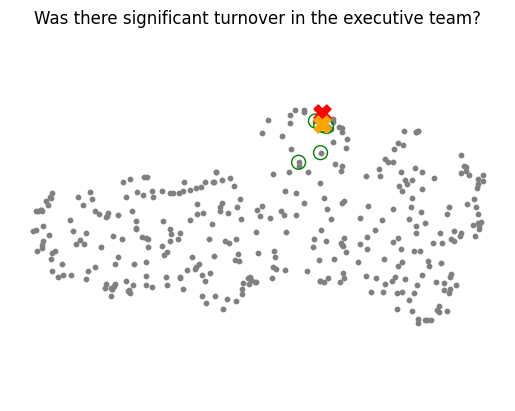

In [9]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Expansion with multiple queries


In [9]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [10]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

- How did the company's net profit margin change from the previous year?
- What were the main drivers behind the company's cost of goods sold?
- How did the company's revenue compare to industry peers?
- Were there any significant fluctuations in operating expenses?
- Did the company mention any future strategies to maintain revenue growth?


In [11]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses
increased $ 1. 7 billion or 8 % driven by investments in commercial
sales and linkedin. sales and marketing included a favorable foreign
currency impact of 2 %. • general and administrative expenses increased
$ 793 million or 16 % driven by investments in corporate functions.
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year
net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 

In [12]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


  0%|          | 0/1 [00:00<?, ?it/s]/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python

In [13]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


  0%|          | 0/30 [00:00<?, ?it/s]/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mdp/Desktop/furkan/nlp/nlp-tutorials/43_Advanced_Retrieval_for_AI_with_Chroma/.venv/lib/python3.13/site-packages/sklearn/utils/dep

(-0.41215669363737106,
 11.028811119496822,
 0.5626984030008316,
 5.9737506121397015)

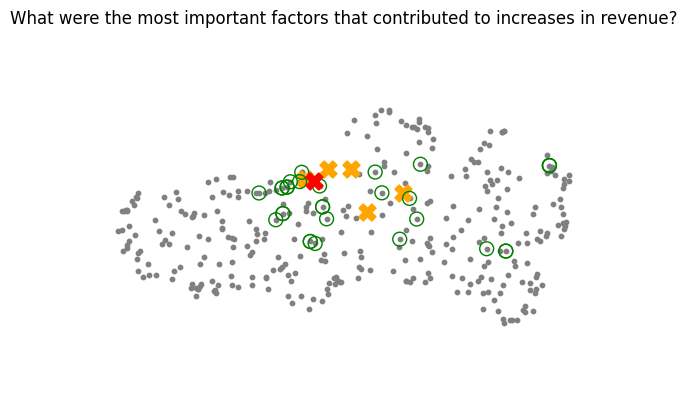

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')